In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from scipy.signal import savgol_filter
from scipy.sparse.linalg import spsolve
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Libraries imported successfully!")
print(f"Working directory: {os.getcwd()}")

✓ Libraries imported successfully!
Working directory: /content


## 1. Load SERS Spectral Data

Loading the Arsenic (As) SERS data from text files.

In [3]:
# Define data directory - UPDATE THIS PATH FOR YOUR ENVIRONMENT
# For Google Colab:
data_dir = Path(r'/content/drive/MyDrive/AS')
# For local:
# data_dir = Path(r'c:\Users\Mossab Arektout\Desktop\tomo\AS')

# Define concentration classes for Arsenic
as_files = [
    '00_Control.txt',
    '01_5x10^-3 pM.txt',
    '02_5x10^-2 pM.txt',
    '03_5x10^-4 nM.txt',
    '04_5x10^-3 nM.txt',
    '05_0.05 nM.txt',
    '06_0.5 nM.txt',
    '07_5 nM.txt',
    '08_50 nM.txt',
    '09_0.5 uM.txt',
    '10_5 uM.txt',
    '11_50 uM.txt',
    '12_0.5 M.txt',
    '13_5 M.txt'
]

as_concentrations = [
    'Control',
    '5×10⁻³ pM',
    '5×10⁻² pM',
    '5×10⁻⁴ nM',
    '5×10⁻³ nM',
    '0.05 nM',
    '0.5 nM',
    '5 nM',
    '50 nM',
    '0.5 µM',
    '5 µM',
    '50 µM',
    '0.5 M',
    '5 M'
]

print(f"Number of concentration classes: {len(as_files)}")
print(f"\nFiles to load:")
for i, (file, conc) in enumerate(zip(as_files, as_concentrations)):
    print(f"  Class {i}: {conc:15s} - {file}")

Number of concentration classes: 14

Files to load:
  Class 0: Control         - 00_Control.txt
  Class 1: 5×10⁻³ pM       - 01_5x10^-3 pM.txt
  Class 2: 5×10⁻² pM       - 02_5x10^-2 pM.txt
  Class 3: 5×10⁻⁴ nM       - 03_5x10^-4 nM.txt
  Class 4: 5×10⁻³ nM       - 04_5x10^-3 nM.txt
  Class 5: 0.05 nM         - 05_0.05 nM.txt
  Class 6: 0.5 nM          - 06_0.5 nM.txt
  Class 7: 5 nM            - 07_5 nM.txt
  Class 8: 50 nM           - 08_50 nM.txt
  Class 9: 0.5 µM          - 09_0.5 uM.txt
  Class 10: 5 µM            - 10_5 uM.txt
  Class 11: 50 µM           - 11_50 uM.txt
  Class 12: 0.5 M           - 12_0.5 M.txt
  Class 13: 5 M             - 13_5 M.txt


In [4]:
# Fixed number of spectral points (as per the paper methodology)
N_POINTS = 1011

def load_sers_data_robust(filepath, n_points=1011, max_spectra=None):
    """
    Load SERS spectral data from text file with robust handling of inconsistent columns.

    Parameters:
    -----------
    filepath : str or Path
        Path to the data file
    n_points : int
        Number of spectral points per spectrum (default 1011)
    max_spectra : int, optional
        Maximum number of spectra to load (for memory management)

    Returns:
    --------
    spectra : ndarray
        Array of SERS spectra (n_spectra, n_points)
    wavenumbers : ndarray
        Wavenumber values (first n_points unique values)
    """
    print(f"Loading: {Path(filepath).name}...", end=' ')

    # Read file line by line and filter for lines with 4 columns
    valid_rows = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 4:
                try:
                    row = [float(parts[0]), float(parts[1]), float(parts[2]), float(parts[3])]
                    valid_rows.append(row)
                except ValueError:
                    continue

    data = np.array(valid_rows)

    # Extract wavenumbers (column 3, index 2) and intensities (column 4, index 3)
    wavenumbers_all = data[:, 2]
    intensities = data[:, 3]

    # Calculate number of complete spectra
    n_spectra = len(intensities) // n_points

    # Limit spectra if requested
    if max_spectra is not None and n_spectra > max_spectra:
        n_spectra = max_spectra

    # Reshape into spectra matrix with fixed n_points
    spectra = intensities[:n_spectra * n_points].reshape(n_spectra, n_points)

    # Get wavenumbers from first spectrum
    wavenumbers = wavenumbers_all[:n_points]

    print(f"Loaded {n_spectra} spectra with {n_points} points each")

    return spectra, wavenumbers

print("Data loading function defined.")

Data loading function defined.


In [5]:
# Load all SERS data
# For memory efficiency, we'll load 1200 spectra per class (as in the paper)
# Control class will have more samples (simulating the paper's approach)

print("Loading SERS spectral data for Arsenic (As)...\n")

X_list = []
y_list = []
wavenumbers = None

for class_idx, (filename, conc_name) in enumerate(zip(as_files, as_concentrations)):
    filepath = data_dir / filename

    # Control class gets more samples (as per paper methodology)
    max_spec = 8000 if class_idx == 0 else 1200

    spectra, wn = load_sers_data_robust(filepath, n_points=N_POINTS, max_spectra=max_spec)

    if wavenumbers is None:
        wavenumbers = wn

    X_list.append(spectra)
    y_list.extend([class_idx] * len(spectra))

# Combine all data
X = np.vstack(X_list)
y = np.array(y_list)

print(f"\n{'='*60}")
print(f"DATASET SUMMARY - ARSENIC (As)")
print(f"{'='*60}")
print(f"Total spectra: {X.shape[0]:,}")
print(f"Spectral points per spectrum: {X.shape[1]:,}")
print(f"Wavenumber range: {wavenumbers.min():.2f} - {wavenumbers.max():.2f} cm^-1")
print(f"Number of classes: {len(np.unique(y))}")
print(f"\nClass distribution:")
for i, conc in enumerate(as_concentrations):
    count = np.sum(y == i)
    print(f"  {conc:15s}: {count:5d} spectra")
print(f"{'='*60}")

Loading SERS spectral data for Arsenic (As)...

Loading: 00_Control.txt... Loaded 8000 spectra with 1011 points each
Loading: 01_5x10^-3 pM.txt... Loaded 1200 spectra with 1011 points each
Loading: 02_5x10^-2 pM.txt... Loaded 1200 spectra with 1011 points each
Loading: 03_5x10^-4 nM.txt... Loaded 1200 spectra with 1011 points each
Loading: 04_5x10^-3 nM.txt... Loaded 1200 spectra with 1011 points each
Loading: 05_0.05 nM.txt... Loaded 1200 spectra with 1011 points each
Loading: 06_0.5 nM.txt... Loaded 1200 spectra with 1011 points each
Loading: 07_5 nM.txt... Loaded 1200 spectra with 1011 points each
Loading: 08_50 nM.txt... Loaded 1200 spectra with 1011 points each
Loading: 09_0.5 uM.txt... Loaded 1200 spectra with 1011 points each
Loading: 10_5 uM.txt... Loaded 1200 spectra with 1011 points each
Loading: 11_50 uM.txt... Loaded 1200 spectra with 1011 points each
Loading: 12_0.5 M.txt... Loaded 1200 spectra with 1011 points each
Loading: 13_5 M.txt... Loaded 1200 spectra with 1011 poin

## 2. Data Visualization

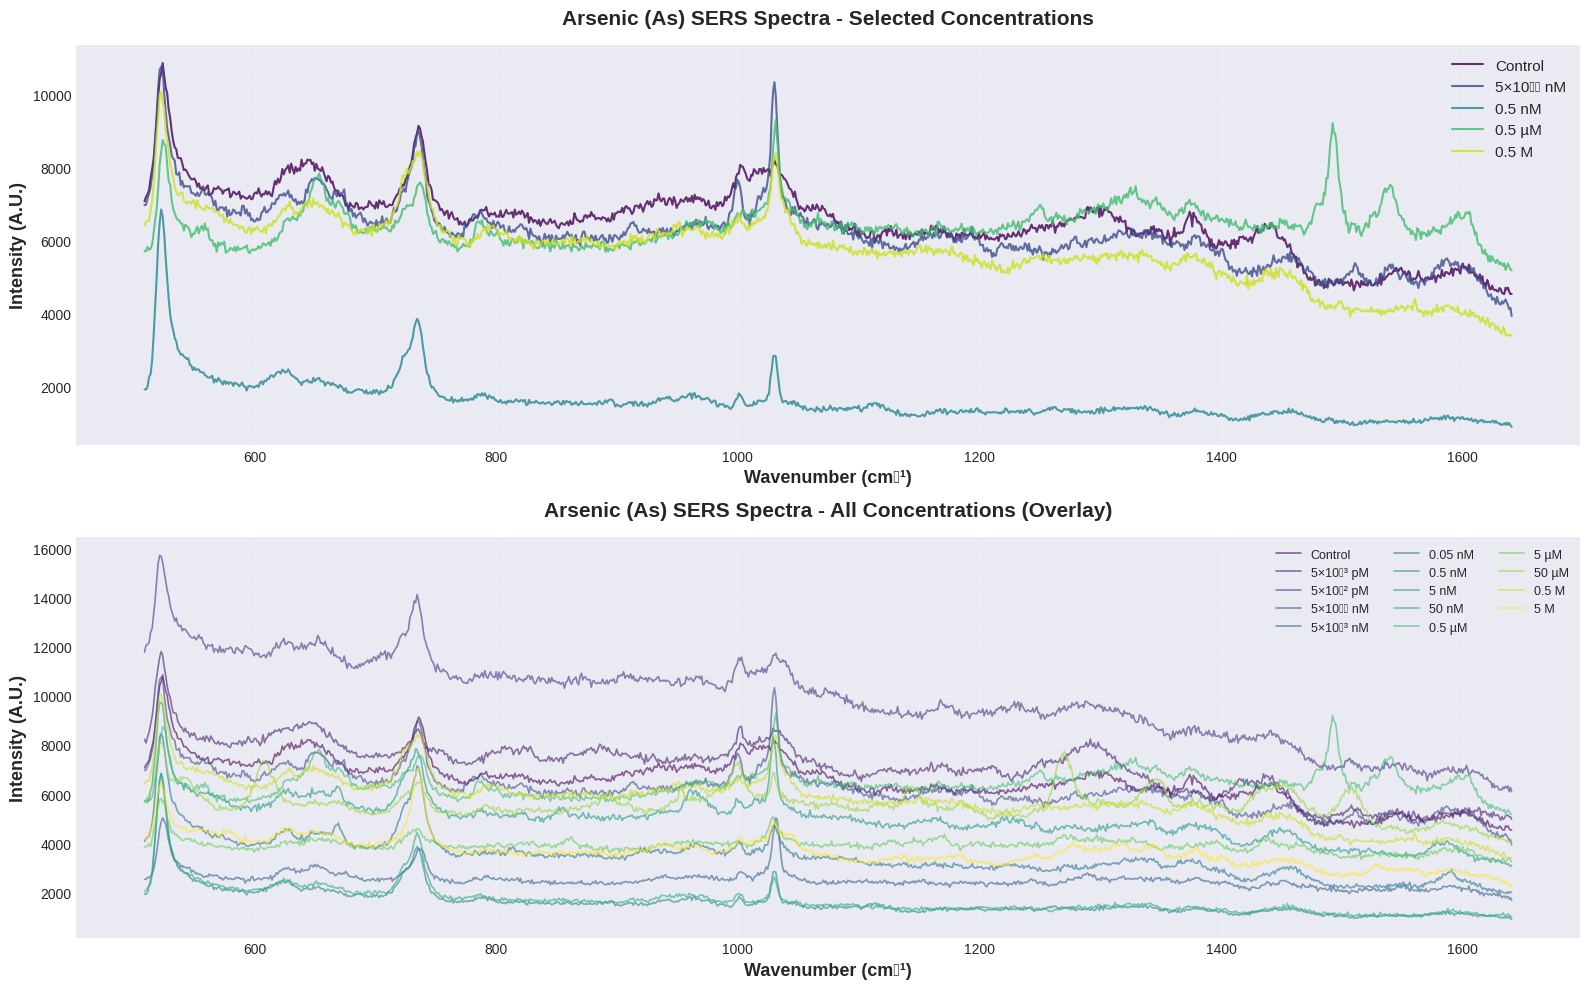

In [6]:
# Plot sample spectra for different concentrations
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Selected concentrations
colors = plt.cm.viridis(np.linspace(0, 1, len(as_concentrations)))
selected_indices = [0, 3, 6, 9, 12]  # Control, 5×10⁻⁴ nM, 0.5 nM, 0.5 µM, 0.5 M
for i in selected_indices:
    idx = np.where(y == i)[0][0]
    axes[0].plot(wavenumbers, X[idx], label=as_concentrations[i],
                color=colors[i], alpha=0.8, linewidth=1.5)

axes[0].set_xlabel('Wavenumber (cm⁻¹)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Intensity (A.U.)', fontsize=13, fontweight='bold')
axes[0].set_title('Arsenic (As) SERS Spectra - Selected Concentrations',
                  fontsize=15, fontweight='bold', pad=15)
axes[0].legend(fontsize=11, loc='best')
axes[0].grid(True, alpha=0.3, linestyle='--')

# Plot 2: All concentrations (overlay)
for i in range(len(as_concentrations)):
    idx = np.where(y == i)[0][0]
    axes[1].plot(wavenumbers, X[idx], label=as_concentrations[i],
                color=colors[i], alpha=0.6, linewidth=1.2)

axes[1].set_xlabel('Wavenumber (cm⁻¹)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Intensity (A.U.)', fontsize=13, fontweight='bold')
axes[1].set_title('Arsenic (As) SERS Spectra - All Concentrations (Overlay)',
                  fontsize=15, fontweight='bold', pad=15)
axes[1].legend(fontsize=9, loc='best', ncol=3)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

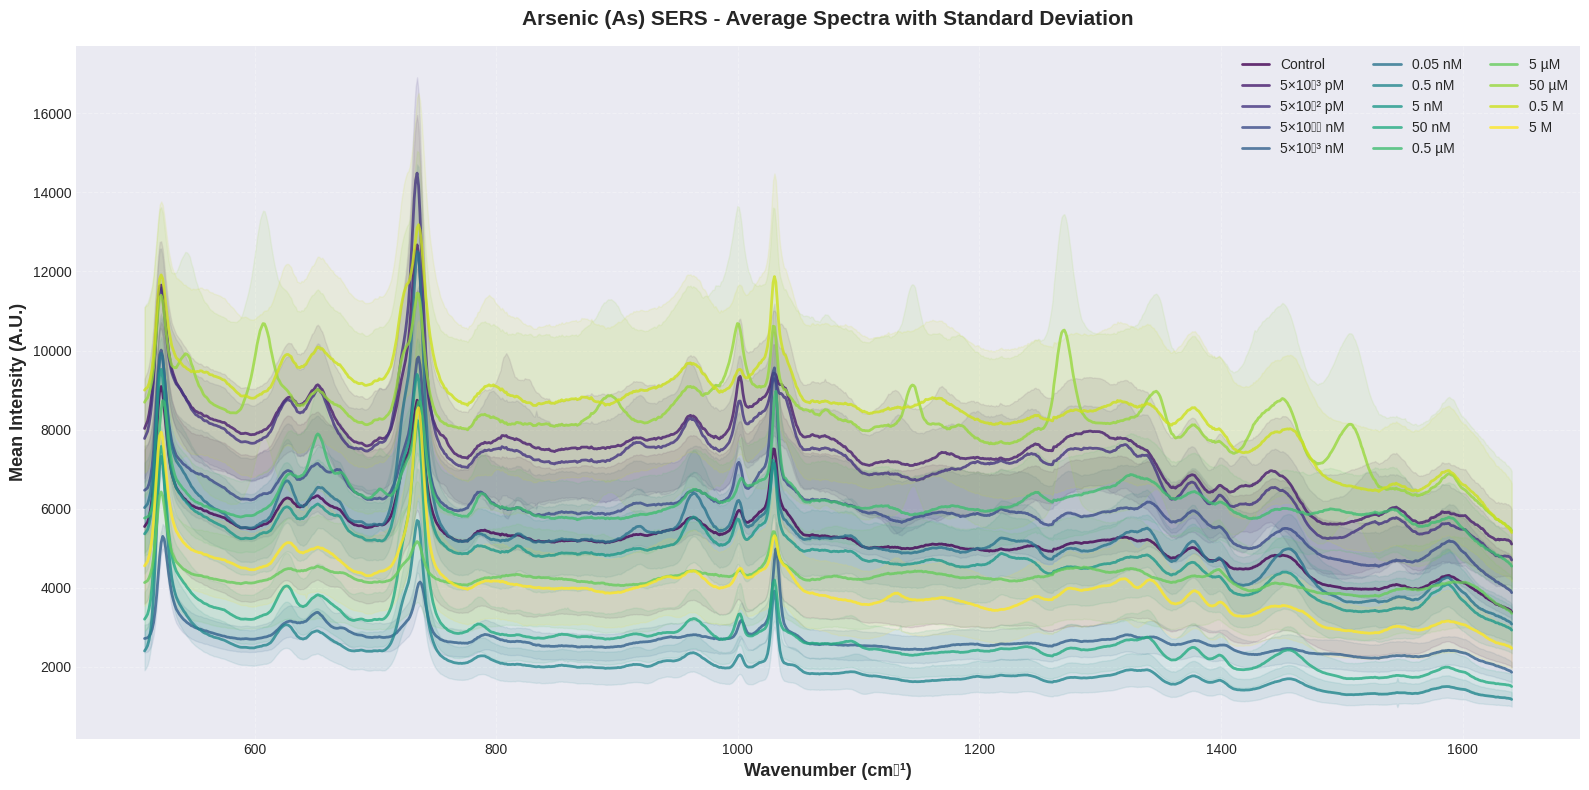

In [7]:
# Plot average spectra per concentration
fig, ax = plt.subplots(figsize=(16, 8))

for i, conc in enumerate(as_concentrations):
    class_spectra = X[y == i]
    mean_spectrum = np.mean(class_spectra, axis=0)
    std_spectrum = np.std(class_spectra, axis=0)

    ax.plot(wavenumbers, mean_spectrum, label=conc,
           color=colors[i], linewidth=2, alpha=0.8)
    ax.fill_between(wavenumbers,
                    mean_spectrum - std_spectrum,
                    mean_spectrum + std_spectrum,
                    color=colors[i], alpha=0.1)

ax.set_xlabel('Wavenumber (cm⁻¹)', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean Intensity (A.U.)', fontsize=13, fontweight='bold')
ax.set_title('Arsenic (As) SERS - Average Spectra with Standard Deviation',
            fontsize=15, fontweight='bold', pad=15)
ax.legend(fontsize=10, loc='best', ncol=3)
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

Following the paper's methodology:
1. **Baseline correction** - Asymmetric Least Squares
2. **Smoothing** - Savitzky-Golay filter
3. **Normalization** - StandardScaler
4. **PCA** - Reduce to 22 components

In [8]:
def baseline_als(y, lam=1e6, p=0.01, niter=10):
    """
    Asymmetric Least Squares baseline correction

    Parameters:
    -----------
    y : array
        Input spectrum
    lam : float
        Smoothness parameter
    p : float
        Asymmetry parameter
    niter : int
        Number of iterations

    Returns:
    --------
    z : array
        Estimated baseline
    """
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

def preprocess_spectrum(spectrum, window_length=11, polyorder=3):
    """
    Preprocess a single SERS spectrum
    """
    # Baseline correction
    baseline = baseline_als(spectrum)
    corrected = spectrum - baseline

    # Smoothing with Savitzky-Golay filter
    smoothed = savgol_filter(corrected, window_length, polyorder)

    return smoothed

print("Preprocessing functions defined.")

Preprocessing functions defined.


In [9]:
# Apply preprocessing to all spectra
print("Applying preprocessing (baseline correction + smoothing)...")
print("This may take a few minutes...\n")

X_preprocessed = np.zeros_like(X)

# Process in batches to show progress
batch_size = 1000
n_batches = int(np.ceil(len(X) / batch_size))

for batch_idx in range(n_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(X))

    for i in range(start_idx, end_idx):
        X_preprocessed[i] = preprocess_spectrum(X[i])

    progress = (end_idx / len(X)) * 100
    print(f"  Progress: {progress:.1f}% ({end_idx}/{len(X)} spectra)")

print("\n✓ Preprocessing complete!")

Applying preprocessing (baseline correction + smoothing)...
This may take a few minutes...

  Progress: 4.2% (1000/23600 spectra)
  Progress: 8.5% (2000/23600 spectra)
  Progress: 12.7% (3000/23600 spectra)
  Progress: 16.9% (4000/23600 spectra)
  Progress: 21.2% (5000/23600 spectra)
  Progress: 25.4% (6000/23600 spectra)
  Progress: 29.7% (7000/23600 spectra)
  Progress: 33.9% (8000/23600 spectra)
  Progress: 38.1% (9000/23600 spectra)
  Progress: 42.4% (10000/23600 spectra)
  Progress: 46.6% (11000/23600 spectra)
  Progress: 50.8% (12000/23600 spectra)
  Progress: 55.1% (13000/23600 spectra)
  Progress: 59.3% (14000/23600 spectra)
  Progress: 63.6% (15000/23600 spectra)
  Progress: 67.8% (16000/23600 spectra)
  Progress: 72.0% (17000/23600 spectra)
  Progress: 76.3% (18000/23600 spectra)
  Progress: 80.5% (19000/23600 spectra)
  Progress: 84.7% (20000/23600 spectra)
  Progress: 89.0% (21000/23600 spectra)
  Progress: 93.2% (22000/23600 spectra)
  Progress: 97.5% (23000/23600 spectra)

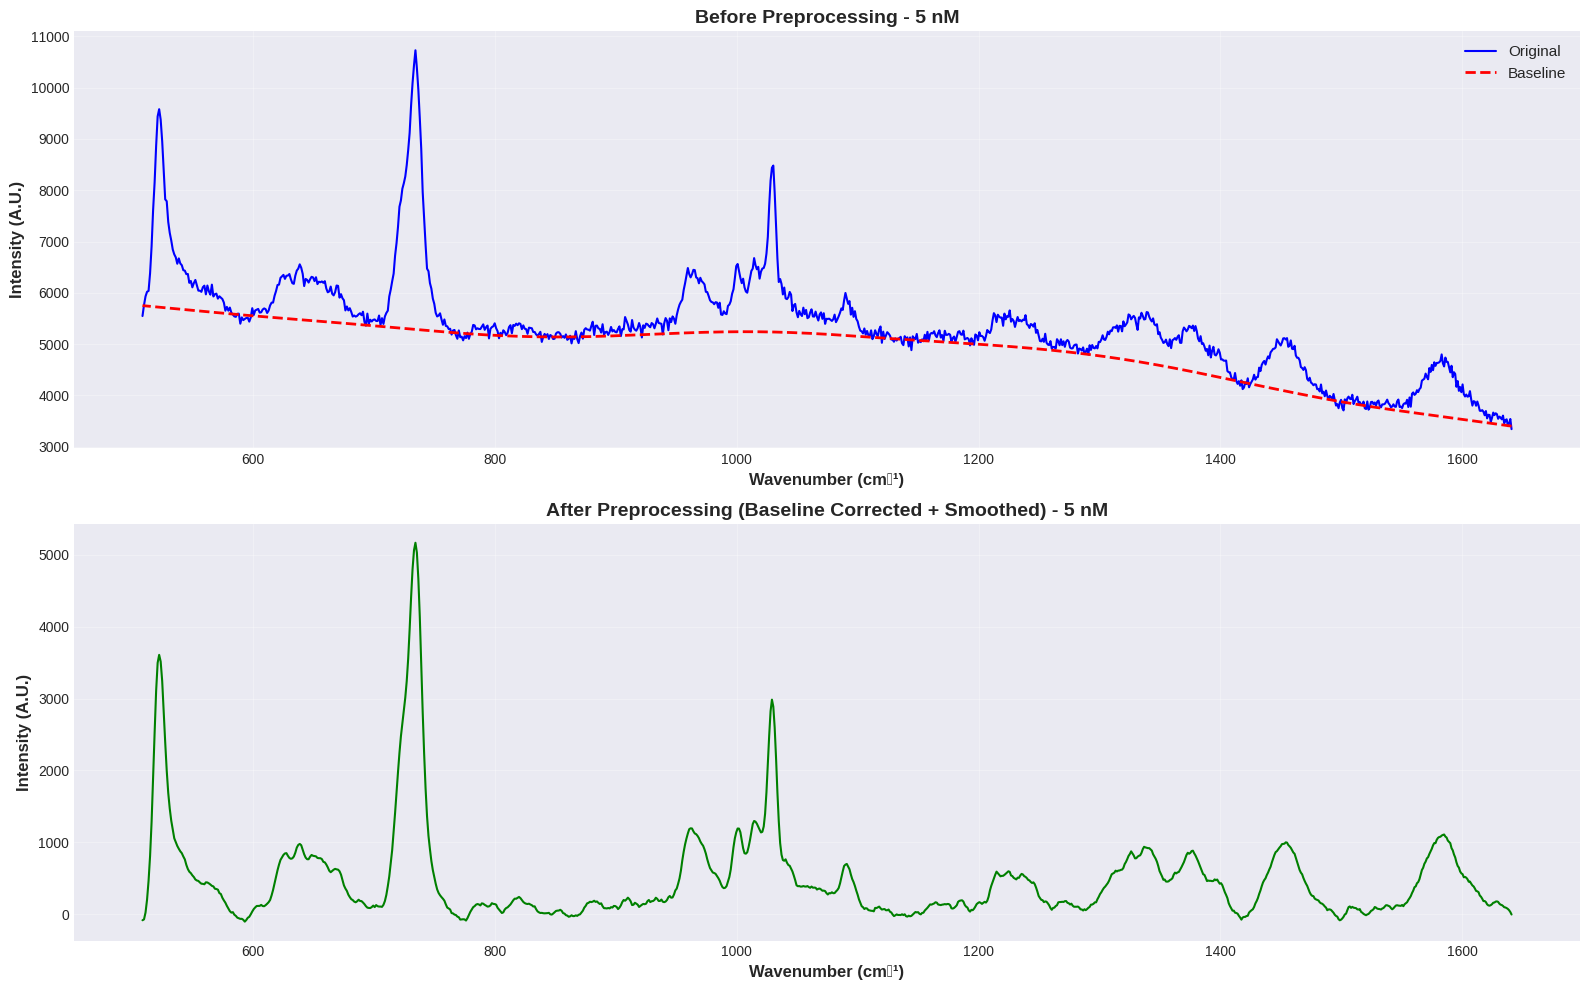

In [10]:
# Visualize effect of preprocessing
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Select a random spectrum
idx = np.random.randint(0, len(X))
class_label = as_concentrations[y[idx]]

# Before preprocessing
axes[0].plot(wavenumbers, X[idx], 'b-', linewidth=1.5, label='Original')
baseline = baseline_als(X[idx])
axes[0].plot(wavenumbers, baseline, 'r--', linewidth=2, label='Baseline')
axes[0].set_xlabel('Wavenumber (cm⁻¹)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Intensity (A.U.)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Before Preprocessing - {class_label}', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# After preprocessing
axes[1].plot(wavenumbers, X_preprocessed[idx], 'g-', linewidth=1.5)
axes[1].set_xlabel('Wavenumber (cm⁻¹)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Intensity (A.U.)', fontsize=12, fontweight='bold')
axes[1].set_title(f'After Preprocessing (Baseline Corrected + Smoothed) - {class_label}',
                 fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Normalization and PCA
print("Applying normalization and PCA...\n")

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_preprocessed)

# PCA for dimensionality reduction
n_components = 22  # As per the paper
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

explained_variance = np.sum(pca.explained_variance_ratio_) * 100

print(f"✓ Normalization complete")
print(f"✓ PCA complete: {n_components} components")
print(f"  Explained variance: {explained_variance:.2f}%")
print(f"\nReduced data shape: {X_pca.shape}")

Applying normalization and PCA...

✓ Normalization complete
✓ PCA complete: 22 components
  Explained variance: 77.16%

Reduced data shape: (23600, 22)


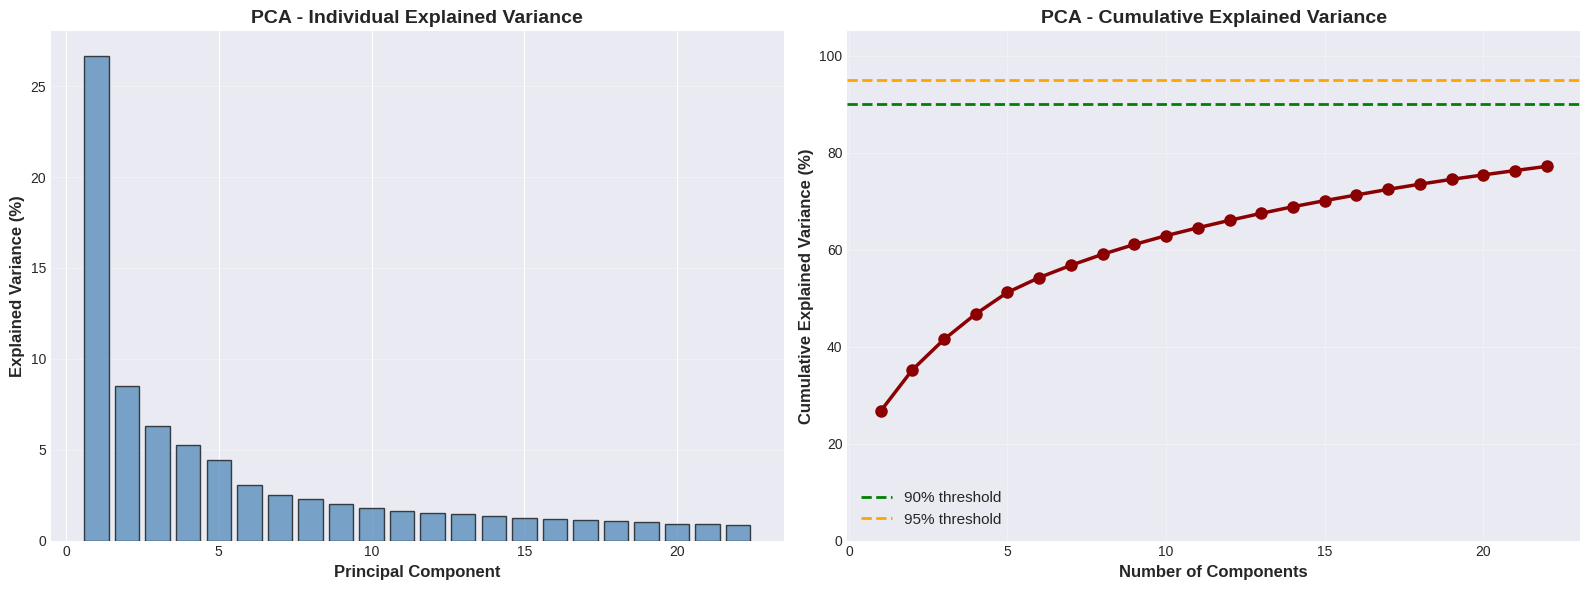

First 10 PCs explain: 62.87% of variance
All 22 PCs explain: 77.16% of variance


In [12]:
# Visualize PCA explained variance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Individual and cumulative explained variance
axes[0].bar(range(1, n_components+1), pca.explained_variance_ratio_ * 100,
           alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Explained Variance (%)', fontsize=12, fontweight='bold')
axes[0].set_title('PCA - Individual Explained Variance', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Cumulative explained variance
cumsum = np.cumsum(pca.explained_variance_ratio_) * 100
axes[1].plot(range(1, n_components+1), cumsum, 'o-', linewidth=2.5,
            markersize=8, color='darkred')
axes[1].axhline(y=90, color='green', linestyle='--', linewidth=2, label='90% threshold')
axes[1].axhline(y=95, color='orange', linestyle='--', linewidth=2, label='95% threshold')
axes[1].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Explained Variance (%)', fontsize=12, fontweight='bold')
axes[1].set_title('PCA - Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 105])

plt.tight_layout()
plt.show()

print(f"First 10 PCs explain: {cumsum[9]:.2f}% of variance")
print(f"All {n_components} PCs explain: {cumsum[-1]:.2f}% of variance")

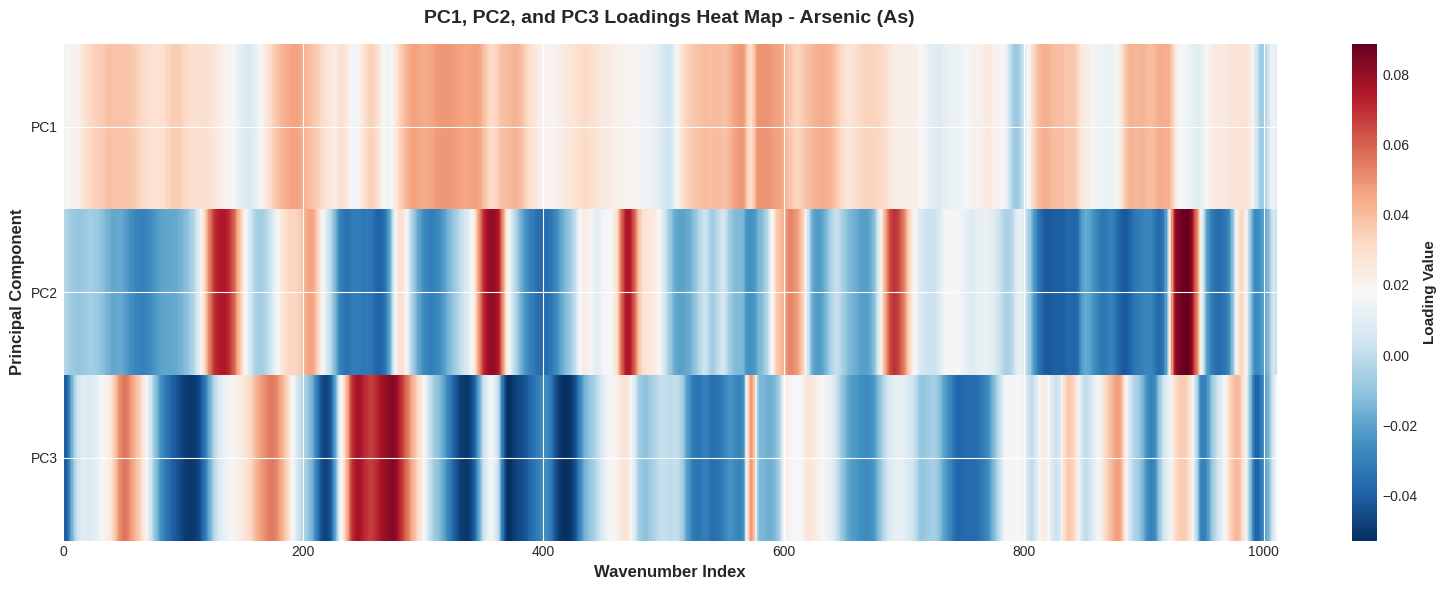

In [13]:
# Plot first 3 principal components as heatmap (as in the paper)
fig, ax = plt.subplots(figsize=(16, 6))

# Create heatmap of PC loadings
pc_loadings = pca.components_[:3, :]
im = ax.imshow(pc_loadings, cmap='RdBu_r', aspect='auto', interpolation='nearest')

ax.set_xlabel('Wavenumber Index', fontsize=12, fontweight='bold')
ax.set_ylabel('Principal Component', fontsize=12, fontweight='bold')
ax.set_title('PC1, PC2, and PC3 Loadings Heat Map - Arsenic (As)', fontsize=14, fontweight='bold', pad=15)
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['PC1', 'PC2', 'PC3'])

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Loading Value', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. t-SNE Visualization (Unsupervised)

Verify that concentration classes are separable in lower-dimensional space

In [14]:
# t-SNE visualization (using subset for computational efficiency)
print("Computing t-SNE embeddings...")
print("(Using subset of spectra for faster computation)\n")

# Sample subset stratified by class
sample_size_per_class = 400
indices = []
for class_idx in range(len(as_concentrations)):
    class_indices = np.where(y == class_idx)[0]
    if len(class_indices) > sample_size_per_class:
        sampled = np.random.choice(class_indices, sample_size_per_class, replace=False)
    else:
        sampled = class_indices
    indices.extend(sampled)

indices = np.array(indices)
X_pca_subset = X_pca[indices]
y_subset = y[indices]

# Compute t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca_subset)

print("✓ t-SNE computation complete!")
print(f"  Embedded {len(X_tsne)} samples into 2D")

Computing t-SNE embeddings...
(Using subset of spectra for faster computation)

✓ t-SNE computation complete!
  Embedded 5600 samples into 2D


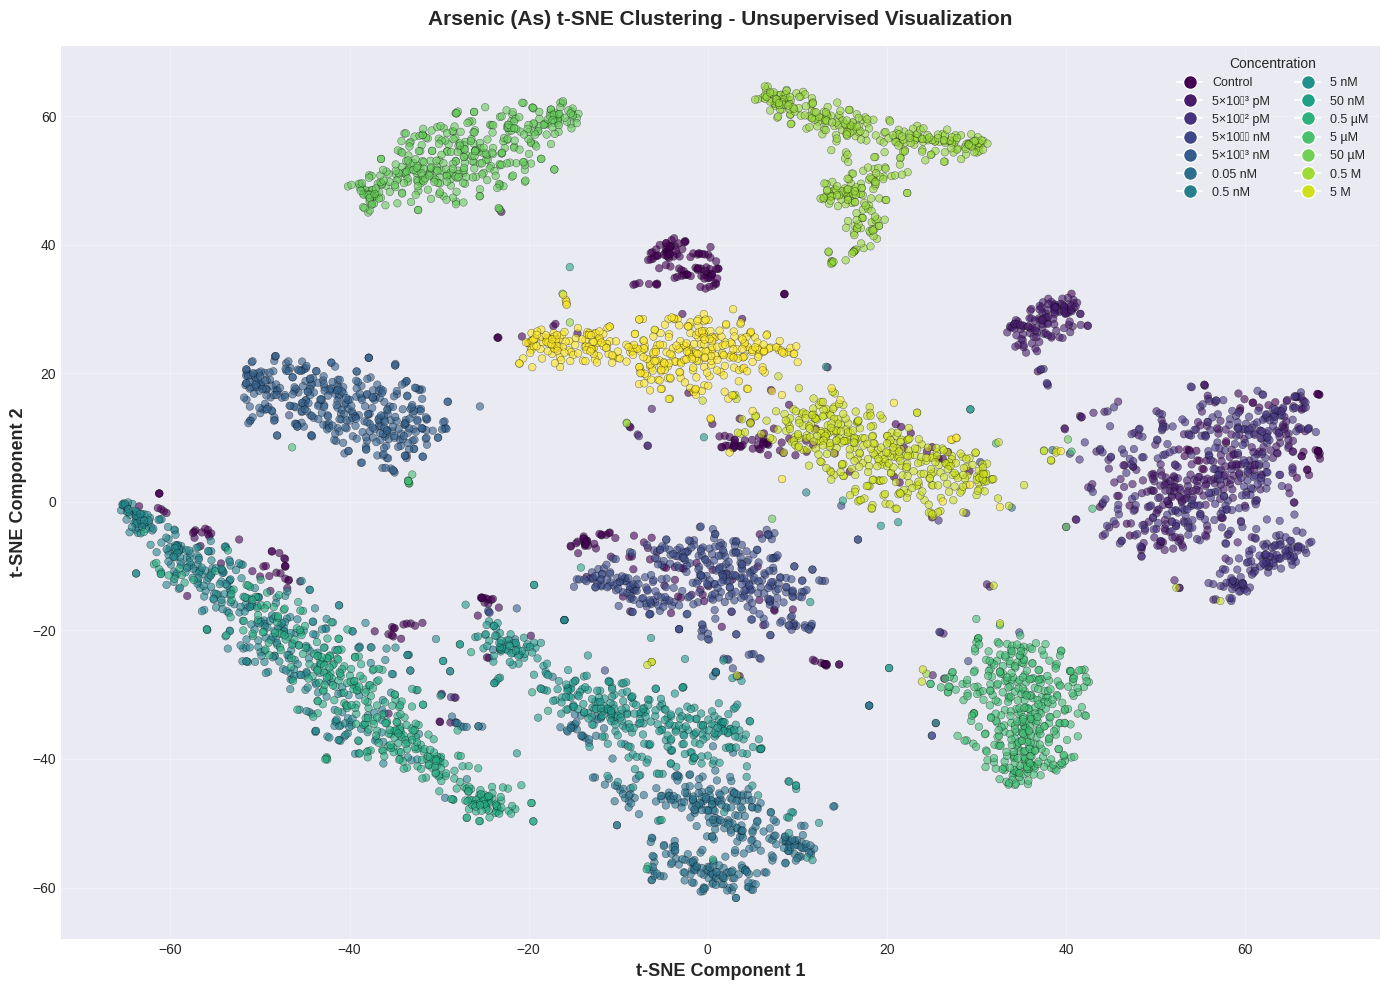

In [15]:
# Plot t-SNE visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Create scatter plot with color-coded classes
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1],
                    c=y_subset, cmap='viridis',
                    alpha=0.6, s=30, edgecolors='black', linewidth=0.3)

ax.set_xlabel('t-SNE Component 1', fontsize=13, fontweight='bold')
ax.set_ylabel('t-SNE Component 2', fontsize=13, fontweight='bold')
ax.set_title('Arsenic (As) t-SNE Clustering - Unsupervised Visualization',
            fontsize=15, fontweight='bold', pad=15)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w',
                         markerfacecolor=plt.cm.viridis(i/len(as_concentrations)),
                         markersize=10, label=conc)
                  for i, conc in enumerate(as_concentrations)]
ax.legend(handles=legend_elements, loc='best', fontsize=9,
         title='Concentration', title_fontsize=10, ncol=2)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Train-Test Split and SMOTE

- 80% training, 20% testing
- Apply SMOTE to balance classes in training set

In [16]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Original dataset split:")
print(f"  Training set: {X_train.shape[0]:,} samples")
print(f"  Test set: {X_test.shape[0]:,} samples")
print(f"\nClass distribution in training set (before SMOTE):")
for i, conc in enumerate(as_concentrations):
    count = np.sum(y_train == i)
    print(f"  {conc:15s}: {count:5d} samples")

Original dataset split:
  Training set: 18,880 samples
  Test set: 4,720 samples

Class distribution in training set (before SMOTE):
  Control        :  6400 samples
  5×10⁻³ pM      :   960 samples
  5×10⁻² pM      :   960 samples
  5×10⁻⁴ nM      :   960 samples
  5×10⁻³ nM      :   960 samples
  0.05 nM        :   960 samples
  0.5 nM         :   960 samples
  5 nM           :   960 samples
  50 nM          :   960 samples
  0.5 µM         :   960 samples
  5 µM           :   960 samples
  50 µM          :   960 samples
  0.5 M          :   960 samples
  5 M            :   960 samples


In [17]:
# Apply SMOTE to balance classes
print("\nApplying SMOTE to balance classes...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\n✓ SMOTE complete!")
print(f"  Training set after SMOTE: {X_train_smote.shape[0]:,} samples")
print(f"\nClass distribution in training set (after SMOTE):")
for i, conc in enumerate(as_concentrations):
    count = np.sum(y_train_smote == i)
    print(f"  {conc:15s}: {count:5d} samples")


Applying SMOTE to balance classes...

✓ SMOTE complete!
  Training set after SMOTE: 89,600 samples

Class distribution in training set (after SMOTE):
  Control        :  6400 samples
  5×10⁻³ pM      :  6400 samples
  5×10⁻² pM      :  6400 samples
  5×10⁻⁴ nM      :  6400 samples
  5×10⁻³ nM      :  6400 samples
  0.05 nM        :  6400 samples
  0.5 nM         :  6400 samples
  5 nM           :  6400 samples
  50 nM          :  6400 samples
  0.5 µM         :  6400 samples
  5 µM           :  6400 samples
  50 µM          :  6400 samples
  0.5 M          :  6400 samples
  5 M            :  6400 samples


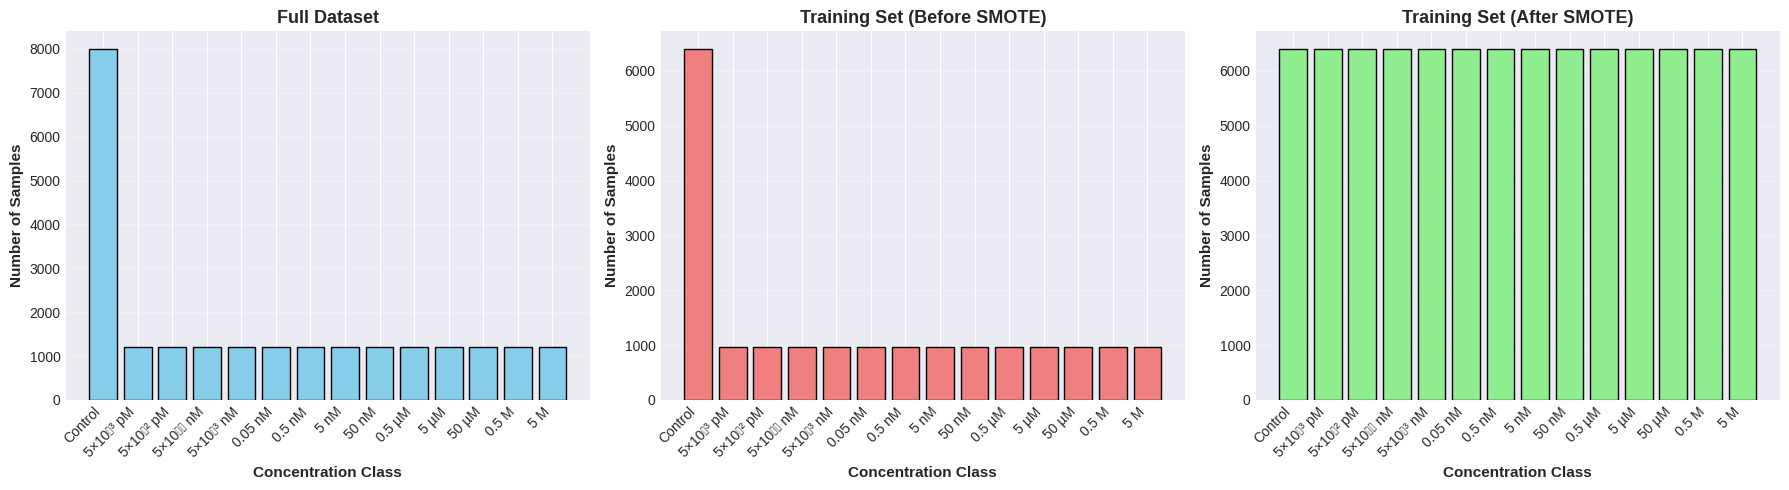

In [18]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Before split
class_counts = [np.sum(y == i) for i in range(len(as_concentrations))]
axes[0].bar(range(len(as_concentrations)), class_counts, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Concentration Class', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
axes[0].set_title('Full Dataset', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(len(as_concentrations)))
axes[0].set_xticklabels(as_concentrations, rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Training set before SMOTE
train_counts = [np.sum(y_train == i) for i in range(len(as_concentrations))]
axes[1].bar(range(len(as_concentrations)), train_counts, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Concentration Class', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
axes[1].set_title('Training Set (Before SMOTE)', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(len(as_concentrations)))
axes[1].set_xticklabels(as_concentrations, rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

# Training set after SMOTE
smote_counts = [np.sum(y_train_smote == i) for i in range(len(as_concentrations))]
axes[2].bar(range(len(as_concentrations)), smote_counts, color='lightgreen', edgecolor='black')
axes[2].set_xlabel('Concentration Class', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
axes[2].set_title('Training Set (After SMOTE)', fontsize=13, fontweight='bold')
axes[2].set_xticks(range(len(as_concentrations)))
axes[2].set_xticklabels(as_concentrations, rotation=45, ha='right')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Support Vector Machine (SVM) Classification

In [19]:
# Train SVM classifier
print("Training SVM classifier with RBF kernel...\n")

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_smote, y_train_smote)

print("✓ SVM training complete!")

# Predict on test set
y_pred_svm = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average='weighted')

print(f"\n{'='*60}")
print(f"SVM CLASSIFICATION RESULTS - ARSENIC (As)")
print(f"{'='*60}")
print(f"Test Accuracy: {svm_accuracy*100:.2f}%")
print(f"Weighted F1-Score: {svm_f1:.4f}")
print(f"{'='*60}")

Training SVM classifier with RBF kernel...

✓ SVM training complete!

SVM CLASSIFICATION RESULTS - ARSENIC (As)
Test Accuracy: 90.38%
Weighted F1-Score: 0.9061


In [20]:
# Detailed classification report
print("\nDetailed Classification Report (SVM):\n")
print(classification_report(y_test, y_pred_svm,
                           target_names=as_concentrations,
                           digits=4,
                           zero_division=0))


Detailed Classification Report (SVM):

              precision    recall  f1-score   support

     Control     0.9452    0.8512    0.8958      1600
   5×10⁻³ pM     0.8646    0.8250    0.8443       240
   5×10⁻² pM     0.8634    0.8167    0.8394       240
   5×10⁻⁴ nM     0.6036    0.9708    0.7444       240
   5×10⁻³ nM     1.0000    0.9917    0.9958       240
     0.05 nM     0.9280    0.9667    0.9469       240
      0.5 nM     0.8287    0.8667    0.8473       240
        5 nM     0.9076    0.9417    0.9243       240
       50 nM     0.8382    0.8417    0.8399       240
      0.5 µM     1.0000    0.9792    0.9895       240
        5 µM     0.9958    0.9875    0.9916       240
       50 µM     0.9917    0.9917    0.9917       240
       0.5 M     0.8808    0.9542    0.9160       240
         5 M     0.9872    0.9667    0.9768       240

    accuracy                         0.9038      4720
   macro avg     0.9025    0.9251    0.9103      4720
weighted avg     0.9148    0.9038    0.9

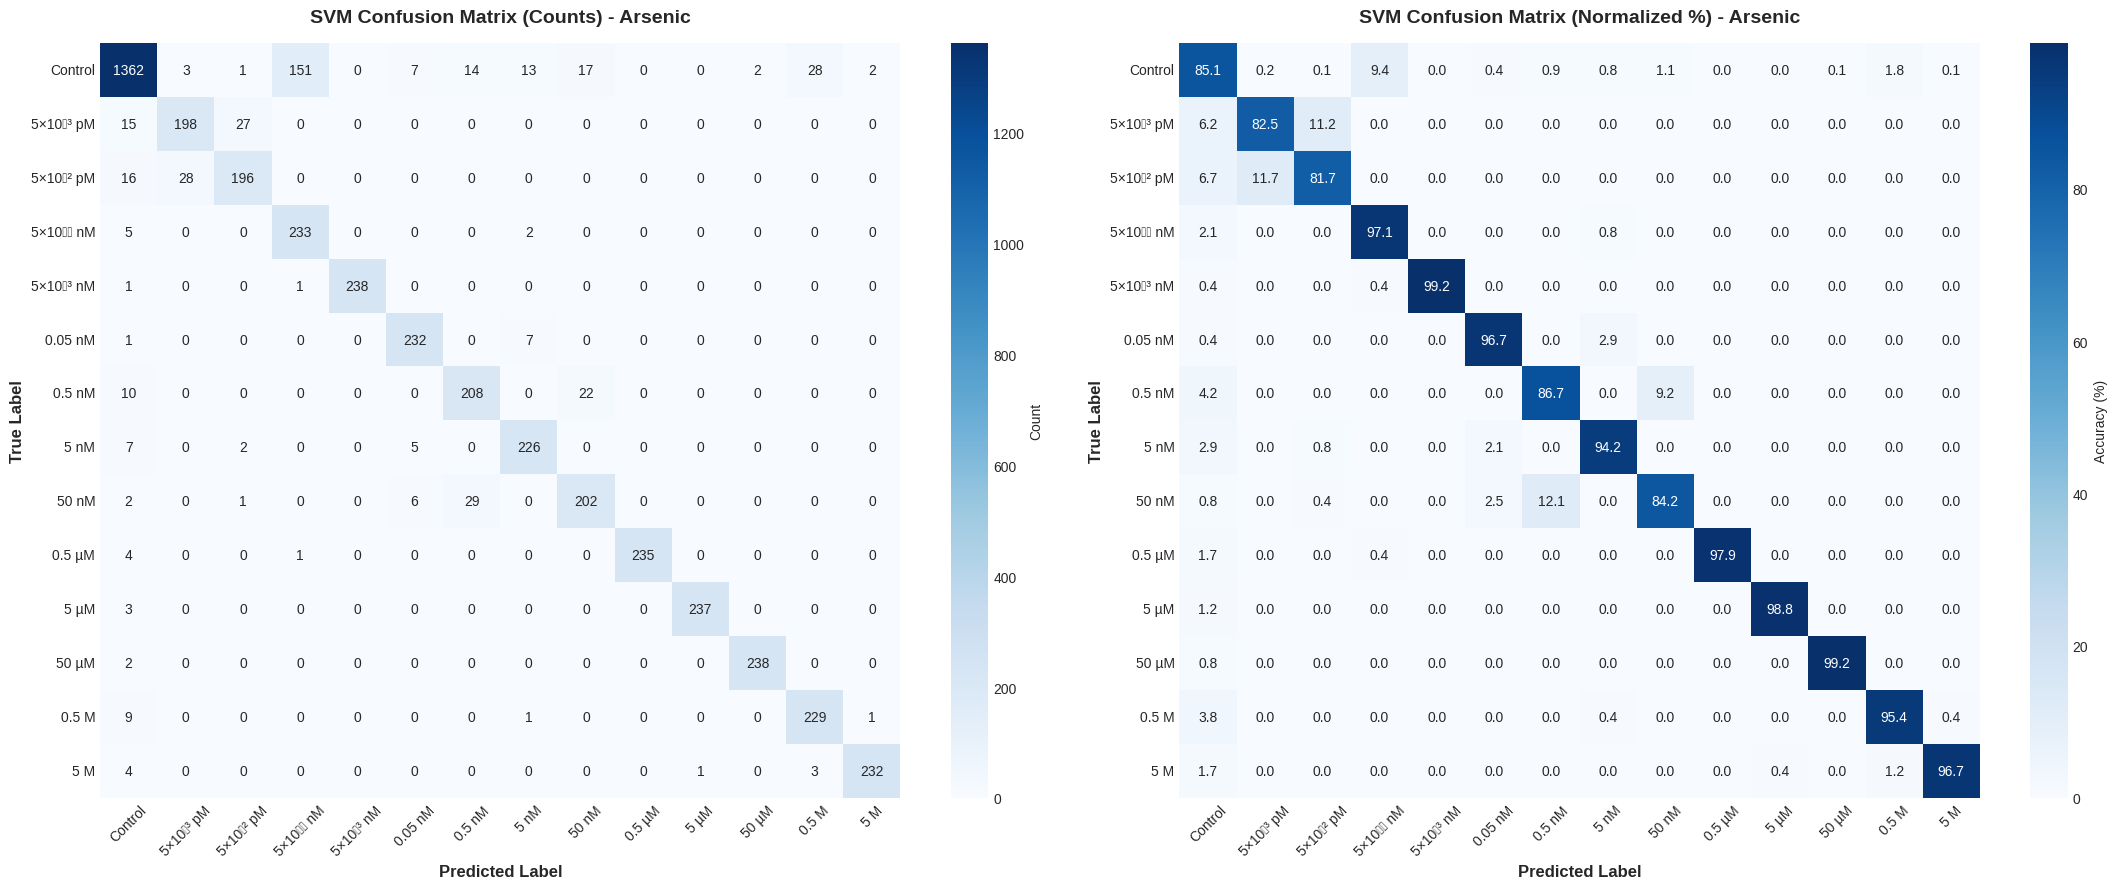

In [21]:
# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_svm_normalized = cm_svm.astype('float') / cm_svm.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(22, 9))

# Absolute counts
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=as_concentrations, yticklabels=as_concentrations,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_title('SVM Confusion Matrix (Counts) - Arsenic', fontsize=14, fontweight='bold', pad=15)
axes[0].tick_params(axis='x', rotation=45)

# Normalized percentages
sns.heatmap(cm_svm_normalized, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=as_concentrations, yticklabels=as_concentrations,
            ax=axes[1], cbar_kws={'label': 'Accuracy (%)'})
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_title('SVM Confusion Matrix (Normalized %) - Arsenic', fontsize=14, fontweight='bold', pad=15)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 7. Random Forest Classification

In [22]:
# Train Random Forest
print("Training Random Forest classifier...\n")

rf_model = RandomForestClassifier(n_estimators=200, max_depth=25,
                                 random_state=42, n_jobs=-1)
rf_model.fit(X_train_smote, y_train_smote)

print("✓ Random Forest training complete!")

# Predict
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print(f"\nRandom Forest Results:")
print(f"  Test Accuracy: {rf_accuracy*100:.2f}%")
print(f"  Weighted F1-Score: {rf_f1:.4f}")

Training Random Forest classifier...

✓ Random Forest training complete!

Random Forest Results:
  Test Accuracy: 90.42%
  Weighted F1-Score: 0.9055


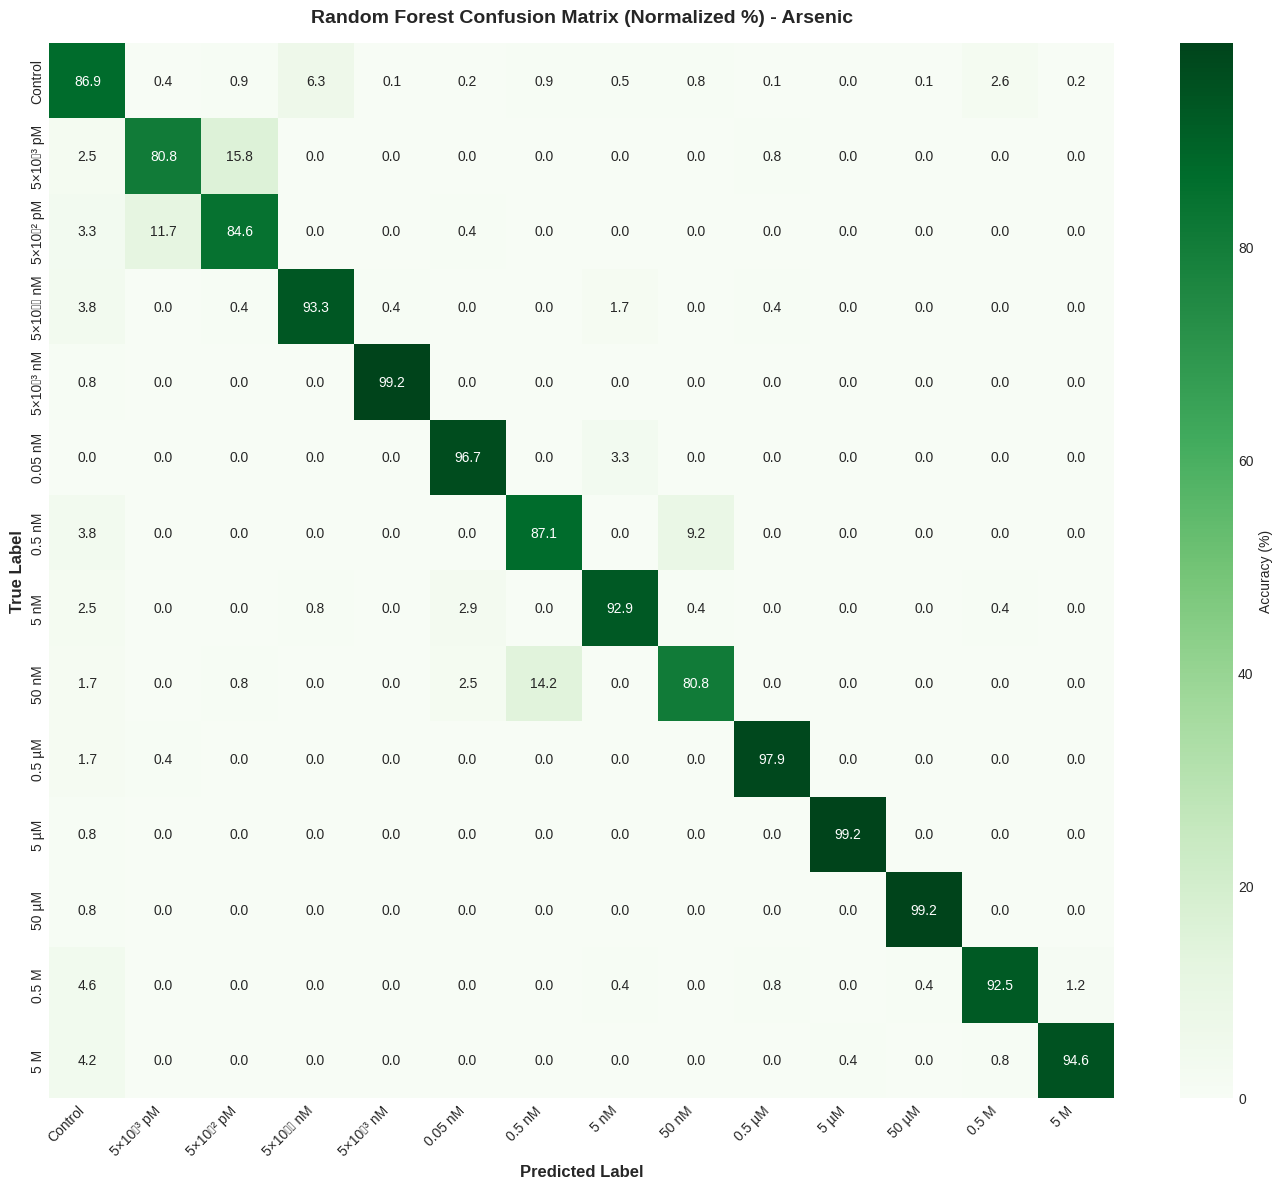

In [23]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf_normalized = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis] * 100

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(cm_rf_normalized, annot=True, fmt='.1f', cmap='Greens',
            xticklabels=as_concentrations, yticklabels=as_concentrations,
            ax=ax, cbar_kws={'label': 'Accuracy (%)'})
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Random Forest Confusion Matrix (Normalized %) - Arsenic',
            fontsize=14, fontweight='bold', pad=15)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 8. Gradient Boosting Classification

In [24]:
# Train Gradient Boosting with improved hyperparameters
print("Training Gradient Boosting classifier...\n")

gb_model = GradientBoostingClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    max_features='sqrt',
    random_state=42,
    verbose=1
)
gb_model.fit(X_train_smote, y_train_smote)

print("\nGradient Boosting training complete!")

# Predict
y_pred_gb = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
gb_f1 = f1_score(y_test, y_pred_gb, average='weighted')

print(f"\n{'='*60}")
print(f"GRADIENT BOOSTING RESULTS - ARSENIC (As)")
print(f"{'='*60}")
print(f"Test Accuracy: {gb_accuracy*100:.2f}%")
print(f"Weighted F1-Score: {gb_f1:.4f}")
print(f"{'='*60}")

Training Gradient Boosting classifier...

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           2.3088           0.3287           30.85m
         2           2.0702           0.2416           34.00m
         3           1.8951           0.1685           33.57m
         4           1.7478           0.1517           32.23m
         5           1.6197           0.1242           32.23m
         6           1.5108           0.1100           31.15m
         7           1.4159           0.0986           32.30m
         8           1.3329           0.0842           31.56m
         9           1.2535           0.0752           31.41m
        10           1.1855           0.0673           31.68m
        20           0.7396           0.0193           29.80m
        30           0.5276           0.0141           28.64m
        40           0.4008           0.0121           27.23m
        50           0.3237           0.0111           26.29m
        60           0.2717

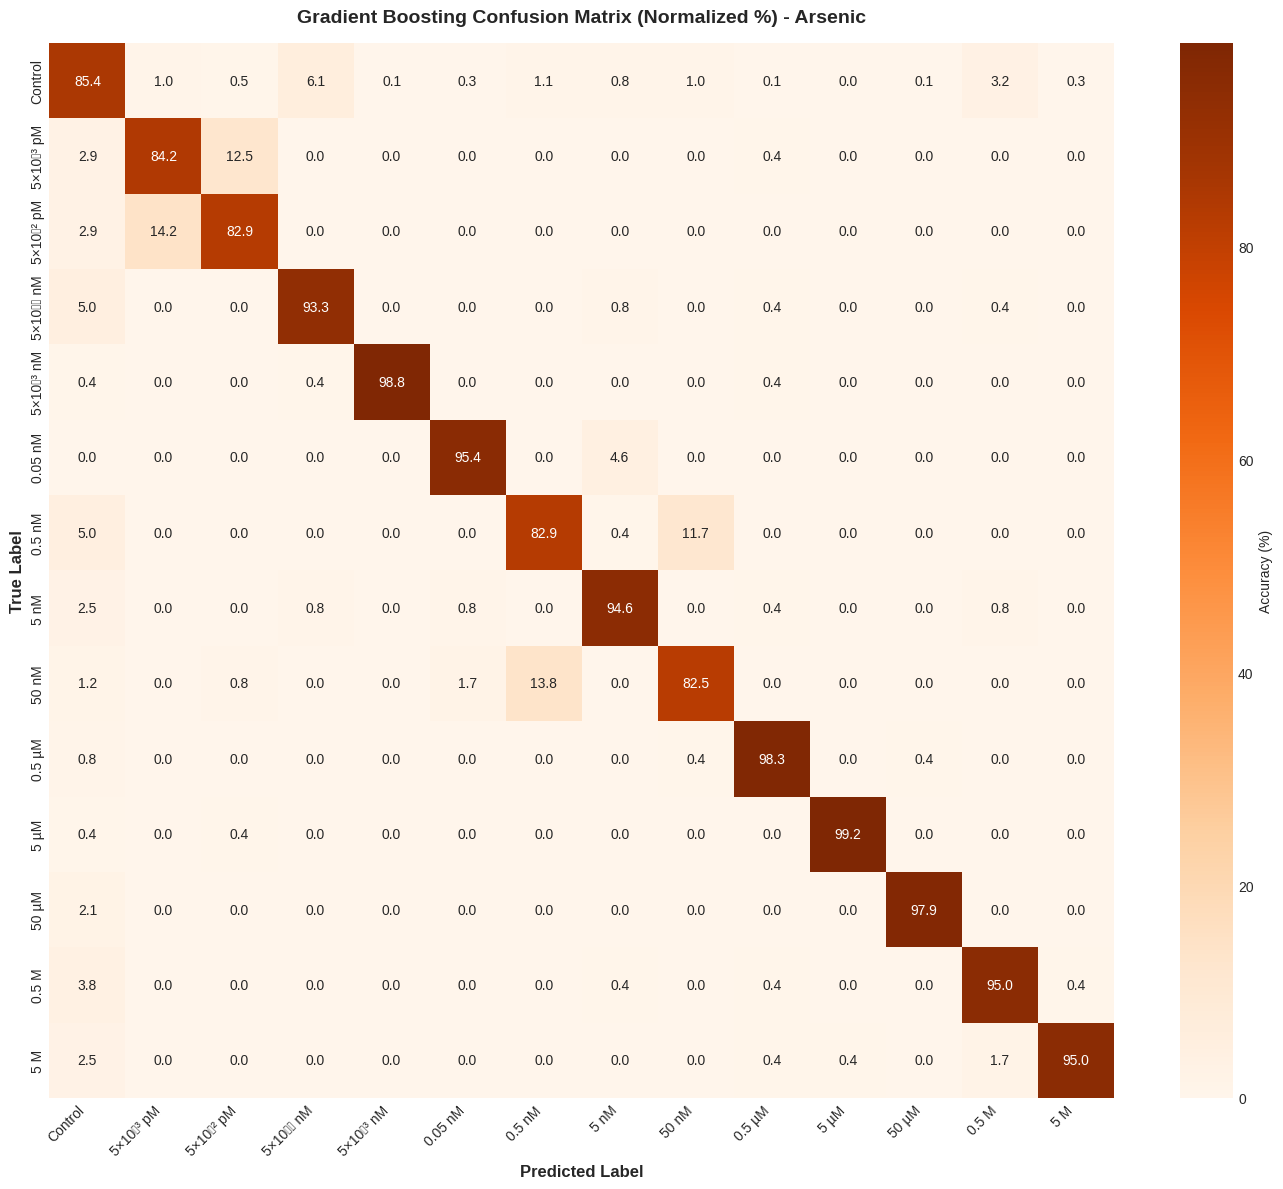

In [25]:
# Confusion Matrix for Gradient Boosting
cm_gb = confusion_matrix(y_test, y_pred_gb)
cm_gb_normalized = cm_gb.astype('float') / cm_gb.sum(axis=1)[:, np.newaxis] * 100

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(cm_gb_normalized, annot=True, fmt='.1f', cmap='Oranges',
            xticklabels=as_concentrations, yticklabels=as_concentrations,
            ax=ax, cbar_kws={'label': 'Accuracy (%)'})
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Gradient Boosting Confusion Matrix (Normalized %) - Arsenic',
            fontsize=14, fontweight='bold', pad=15)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 9. K-Nearest Neighbors (KNN) Classification

In [26]:
# Train KNN
print("Training K-Nearest Neighbors classifier...\n")

knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_model.fit(X_train_smote, y_train_smote)

print("✓ KNN training complete!")

# Predict
y_pred_knn = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn, average='weighted')

print(f"\nKNN Results:")
print(f"  Test Accuracy: {knn_accuracy*100:.2f}%")
print(f"  Weighted F1-Score: {knn_f1:.4f}")

Training K-Nearest Neighbors classifier...

✓ KNN training complete!

KNN Results:
  Test Accuracy: 90.30%
  Weighted F1-Score: 0.9048


## 10. Logistic Regression Classification

In [27]:
# Train Logistic Regression
print("Training Logistic Regression classifier...\n")

lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train_smote, y_train_smote)

print("✓ Logistic Regression training complete!")

# Predict
y_pred_lr = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr, average='weighted')

print(f"\nLogistic Regression Results:")
print(f"  Test Accuracy: {lr_accuracy*100:.2f}%")
print(f"  Weighted F1-Score: {lr_f1:.4f}")

Training Logistic Regression classifier...

✓ Logistic Regression training complete!

Logistic Regression Results:
  Test Accuracy: 81.17%
  Weighted F1-Score: 0.8114


## 11. Cross-Validation Analysis

In [28]:
# 5-fold cross-validation for all models
print("Performing 5-fold cross-validation for all models...\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results for comparison
cv_results = {}

# SVM
print("1. SVM Cross-Validation:")
cv_scores_svm = cross_val_score(svm_model, X_train_smote, y_train_smote,
                                cv=cv, n_jobs=-1, scoring='accuracy')
cv_results['SVM'] = cv_scores_svm
print(f"   Mean CV Accuracy: {cv_scores_svm.mean()*100:.2f}% (+/- {cv_scores_svm.std()*100:.2f}%)")

# Random Forest
print("\n2. Random Forest Cross-Validation:")
cv_scores_rf = cross_val_score(rf_model, X_train_smote, y_train_smote,
                               cv=cv, n_jobs=-1, scoring='accuracy')
cv_results['Random Forest'] = cv_scores_rf
print(f"   Mean CV Accuracy: {cv_scores_rf.mean()*100:.2f}% (+/- {cv_scores_rf.std()*100:.2f}%)")

# KNN
print("\n3. KNN Cross-Validation:")
cv_scores_knn = cross_val_score(knn_model, X_train_smote, y_train_smote,
                                cv=cv, n_jobs=-1, scoring='accuracy')
cv_results['KNN'] = cv_scores_knn
print(f"   Mean CV Accuracy: {cv_scores_knn.mean()*100:.2f}% (+/- {cv_scores_knn.std()*100:.2f}%)")

# Logistic Regression
print("\n4. Logistic Regression Cross-Validation:")
cv_scores_lr = cross_val_score(lr_model, X_train_smote, y_train_smote,
                               cv=cv, n_jobs=-1, scoring='accuracy')
cv_results['Logistic Regression'] = cv_scores_lr
print(f"   Mean CV Accuracy: {cv_scores_lr.mean()*100:.2f}% (+/- {cv_scores_lr.std()*100:.2f}%)")

# Summary table
print(f"\n{'='*70}")
print("CROSS-VALIDATION SUMMARY - ARSENIC (As)")
print(f"{'='*70}")
print(f"{'Model':<25} {'Mean Accuracy':<18} {'Std Dev':<12}")
print(f"{'-'*70}")
for name, scores in cv_results.items():
    print(f"{name:<25} {scores.mean()*100:>6.2f}%           +/- {scores.std()*100:.2f}%")
print(f"{'='*70}")

Performing 5-fold cross-validation for all models...

1. SVM Cross-Validation:
   Mean CV Accuracy: 96.59% (+/- 0.04%)

2. Random Forest Cross-Validation:
   Mean CV Accuracy: 98.59% (+/- 0.08%)

3. KNN Cross-Validation:
   Mean CV Accuracy: 98.53% (+/- 0.09%)

4. Logistic Regression Cross-Validation:
   Mean CV Accuracy: 91.39% (+/- 0.19%)

CROSS-VALIDATION SUMMARY - ARSENIC (As)
Model                     Mean Accuracy      Std Dev     
----------------------------------------------------------------------
SVM                        96.59%           +/- 0.04%
Random Forest              98.59%           +/- 0.08%
KNN                        98.53%           +/- 0.09%
Logistic Regression        91.39%           +/- 0.19%


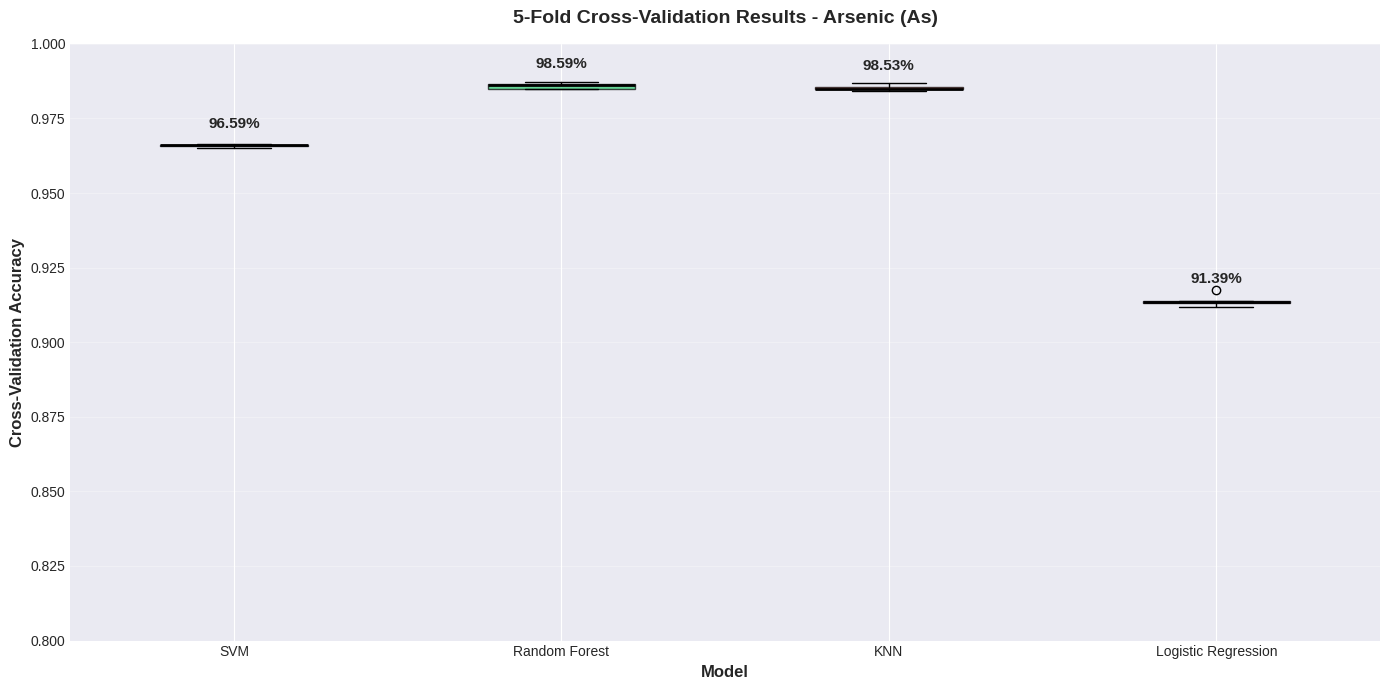

In [29]:
# Visualize cross-validation results
fig, ax = plt.subplots(figsize=(14, 7))

models = ['SVM', 'Random Forest', 'KNN', 'Logistic Regression']
cv_results_list = [cv_scores_svm, cv_scores_rf, cv_scores_knn, cv_scores_lr]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

bp = ax.boxplot(cv_results_list, labels=models, patch_artist=True,
               medianprops=dict(color='black', linewidth=2),
               whiskerprops=dict(color='black'),
               capprops=dict(color='black'))

# Color each box differently
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Cross-Validation Accuracy', fontsize=12, fontweight='bold')
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_title('5-Fold Cross-Validation Results - Arsenic (As)', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.80, 1.0])

# Add mean values
for i, scores in enumerate(cv_results_list, 1):
    ax.text(i, scores.mean() + 0.005, f'{scores.mean()*100:.2f}%',
           ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

## 12. Model Comparison Summary

In [30]:
# Create comprehensive comparison
results_df = pd.DataFrame({
    'Model': ['SVM (RBF)', 'Random Forest', 'Gradient Boosting', 'KNN', 'Logistic Regression'],
    'Test Accuracy (%)': [
        svm_accuracy * 100,
        rf_accuracy * 100,
        gb_accuracy * 100,
        knn_accuracy * 100,
        lr_accuracy * 100
    ],
    'F1-Score': [svm_f1, rf_f1, gb_f1, knn_f1, lr_f1]
})

# Sort by accuracy
results_df = results_df.sort_values('Test Accuracy (%)', ascending=False).reset_index(drop=True)

print("\n" + "="*70)
print(" "*15 + "MODEL COMPARISON SUMMARY - ARSENIC (As)")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)
print(f"\nBest Model: {results_df.iloc[0]['Model']}")
print(f"Best Accuracy: {results_df.iloc[0]['Test Accuracy (%)']:.2f}%")
print("="*70)


               MODEL COMPARISON SUMMARY - ARSENIC (As)
              Model  Test Accuracy (%)  F1-Score
      Random Forest          90.423729  0.905505
          SVM (RBF)          90.381356  0.906089
                KNN          90.296610  0.904773
  Gradient Boosting          89.957627  0.900937
Logistic Regression          81.165254  0.811430

Best Model: Random Forest
Best Accuracy: 90.42%


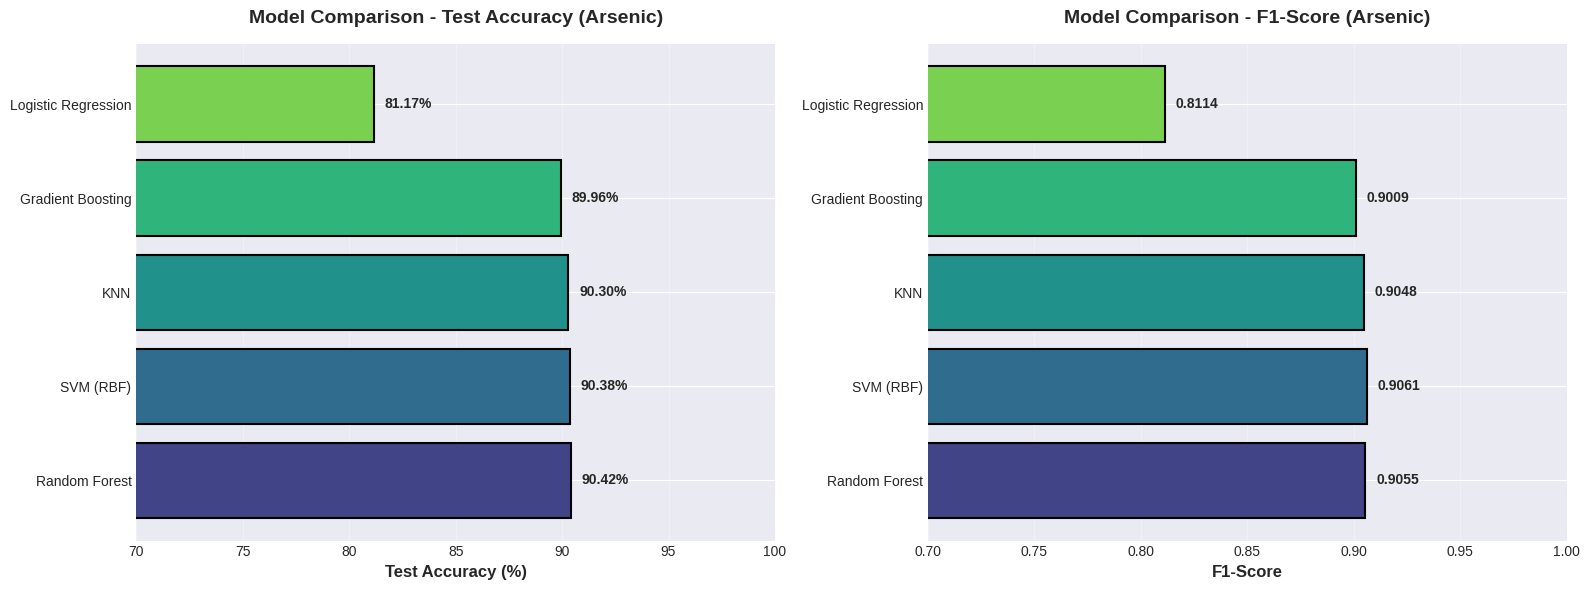

In [31]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define colors for each model
n_models = len(results_df)
colors_bar = plt.cm.viridis(np.linspace(0.2, 0.8, n_models))

# Accuracy comparison
bars1 = axes[0].barh(results_df['Model'], results_df['Test Accuracy (%)'],
                    color=colors_bar, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Model Comparison - Test Accuracy (Arsenic)', fontsize=14, fontweight='bold', pad=15)
axes[0].grid(axis='x', alpha=0.3)
axes[0].set_xlim([70, 100])

# Add value labels
for bar in bars1:
    width = bar.get_width()
    axes[0].text(width + 0.5, bar.get_y() + bar.get_height()/2,
               f'{width:.2f}%', ha='left', va='center',
               fontweight='bold', fontsize=10)

# F1-Score comparison
bars2 = axes[1].barh(results_df['Model'], results_df['F1-Score'],
                    color=colors_bar, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes[1].set_title('Model Comparison - F1-Score (Arsenic)', fontsize=14, fontweight='bold', pad=15)
axes[1].grid(axis='x', alpha=0.3)
axes[1].set_xlim([0.70, 1.0])

# Add value labels
for bar in bars2:
    width = bar.get_width()
    axes[1].text(width + 0.005, bar.get_y() + bar.get_height()/2,
               f'{width:.4f}', ha='left', va='center',
               fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

## 13. Per-Class Performance Analysis

In [32]:
# Analyze performance for each concentration class
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred_svm, labels=range(len(as_concentrations)), zero_division=0
)

per_class_df = pd.DataFrame({
    'Concentration': as_concentrations,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print(f"\n{'='*70}")
print("PER-CLASS PERFORMANCE (SVM) - ARSENIC (As)")
print(f"{'='*70}")
print(per_class_df.to_string(index=False))
print(f"{'='*70}")
print(f"\nBest classified:  {as_concentrations[np.argmax(f1)]} (F1: {np.max(f1):.4f})")
print(f"Worst classified: {as_concentrations[np.argmin(f1)]} (F1: {np.min(f1):.4f})")


PER-CLASS PERFORMANCE (SVM) - ARSENIC (As)
Concentration  Precision   Recall  F1-Score  Support
      Control   0.945177 0.851250  0.895758     1600
    5×10⁻³ pM   0.864629 0.825000  0.844350      240
    5×10⁻² pM   0.863436 0.816667  0.839400      240
    5×10⁻⁴ nM   0.603627 0.970833  0.744409      240
    5×10⁻³ nM   1.000000 0.991667  0.995816      240
      0.05 nM   0.928000 0.966667  0.946939      240
       0.5 nM   0.828685 0.866667  0.847251      240
         5 nM   0.907631 0.941667  0.924335      240
        50 nM   0.838174 0.841667  0.839917      240
       0.5 µM   1.000000 0.979167  0.989474      240
         5 µM   0.995798 0.987500  0.991632      240
        50 µM   0.991667 0.991667  0.991667      240
        0.5 M   0.880769 0.954167  0.916000      240
          5 M   0.987234 0.966667  0.976842      240

Best classified:  5×10⁻³ nM (F1: 0.9958)
Worst classified: 5×10⁻⁴ nM (F1: 0.7444)


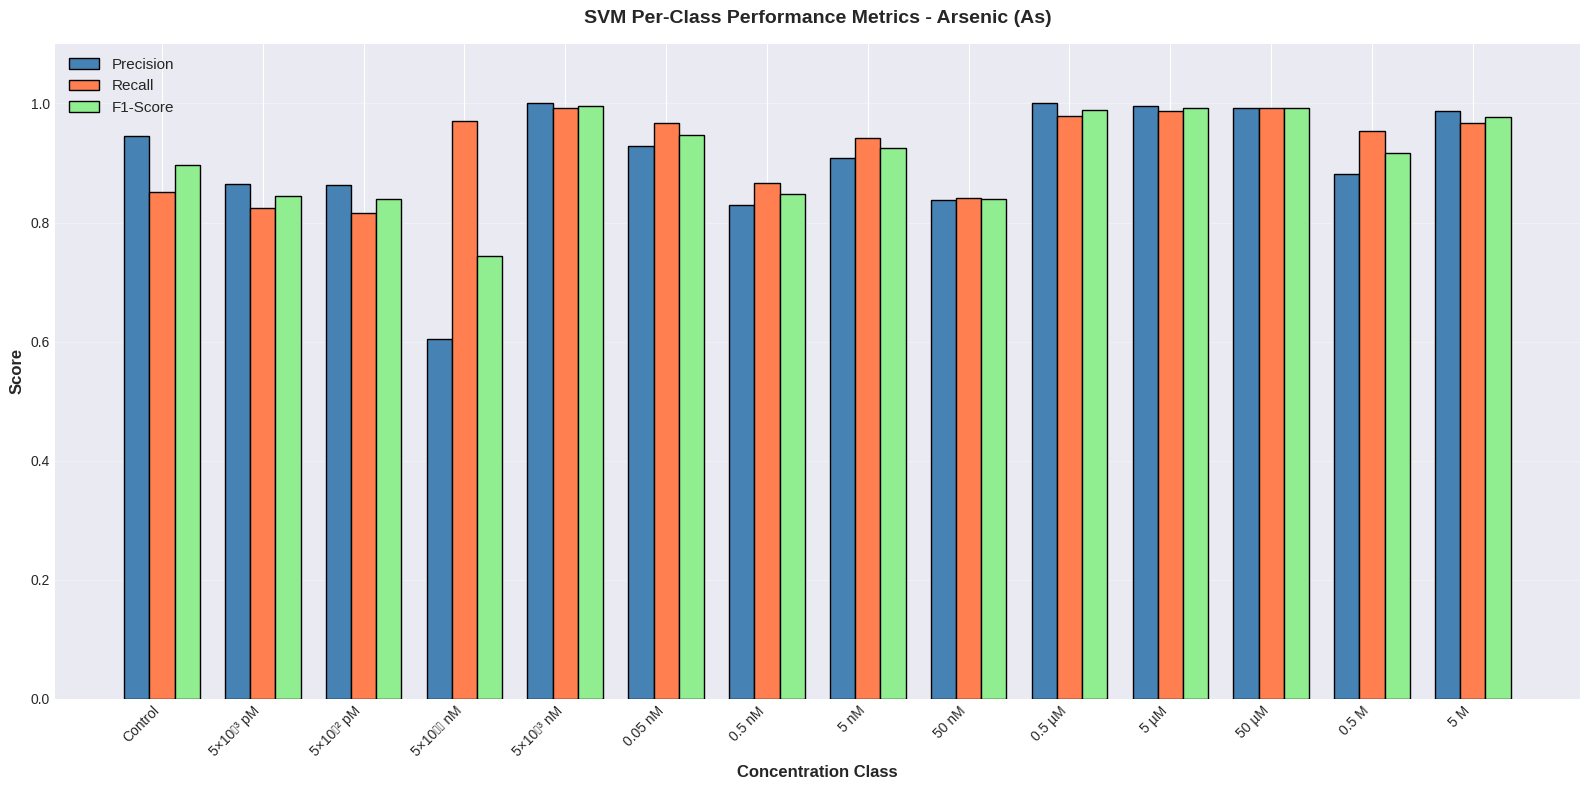

In [33]:
# Visualize per-class performance
fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(as_concentrations))
width = 0.25

bars1 = ax.bar(x - width, per_class_df['Precision'], width,
              label='Precision', color='steelblue', edgecolor='black')
bars2 = ax.bar(x, per_class_df['Recall'], width,
              label='Recall', color='coral', edgecolor='black')
bars3 = ax.bar(x + width, per_class_df['F1-Score'], width,
              label='F1-Score', color='lightgreen', edgecolor='black')

ax.set_xlabel('Concentration Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('SVM Per-Class Performance Metrics - Arsenic (As)', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(as_concentrations, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

## 14. Summary and Conclusions

In [34]:
print("\n" + "="*70)
print(" "*20 + "FINAL SUMMARY - ARSENIC (As) DETECTION")
print("="*70)

print(f"\n📊 DATASET:")
print(f"   - Total spectra: {X.shape[0]:,}")
print(f"   - Spectral points: {X.shape[1]:,}")
print(f"   - Number of classes: {len(as_concentrations)}")
print(f"   - Concentration range: {as_concentrations[1]} to {as_concentrations[-1]}")

print(f"\n🔧 PREPROCESSING:")
print(f"   - Baseline correction: Asymmetric Least Squares")
print(f"   - Smoothing: Savitzky-Golay filter (window=11, order=3)")
print(f"   - Normalization: StandardScaler")
print(f"   - Dimensionality reduction: PCA ({n_components} components, {explained_variance:.2f}% variance)")

print(f"\n📈 BEST MODEL PERFORMANCE:")
best_model = results_df.iloc[0]['Model']
best_accuracy = results_df.iloc[0]['Test Accuracy (%)']
best_f1 = results_df.iloc[0]['F1-Score']
print(f"   - Model: {best_model}")
print(f"   - Test Accuracy: {best_accuracy:.2f}%")
print(f"   - F1-Score: {best_f1:.4f}")

print(f"\n🏆 ALL MODELS RANKING:")
for i, row in results_df.iterrows():
    print(f"   {i+1}. {row['Model']:<20} - Accuracy: {row['Test Accuracy (%)']:.2f}%")

print("\n" + "="*70)
print("✅ Analysis complete for Arsenic (As) heavy metal detection!")
print("="*70)


                    FINAL SUMMARY - ARSENIC (As) DETECTION

📊 DATASET:
   - Total spectra: 23,600
   - Spectral points: 1,011
   - Number of classes: 14
   - Concentration range: 5×10⁻³ pM to 5 M

🔧 PREPROCESSING:
   - Baseline correction: Asymmetric Least Squares
   - Smoothing: Savitzky-Golay filter (window=11, order=3)
   - Normalization: StandardScaler
   - Dimensionality reduction: PCA (22 components, 77.16% variance)

📈 BEST MODEL PERFORMANCE:
   - Model: Random Forest
   - Test Accuracy: 90.42%
   - F1-Score: 0.9055

🏆 ALL MODELS RANKING:
   1. Random Forest        - Accuracy: 90.42%
   2. SVM (RBF)            - Accuracy: 90.38%
   3. KNN                  - Accuracy: 90.30%
   4. Gradient Boosting    - Accuracy: 89.96%
   5. Logistic Regression  - Accuracy: 81.17%

✅ Analysis complete for Arsenic (As) heavy metal detection!
